# Imports
We ensure all necessary modules for both Convolutional and Recurrent layers are loaded.

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import f1_score, classification_report

# Configure hardware
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Algorithm Hardware Target: {device}")

Algorithm Hardware Target: cuda


# Data Loading and Sequence Preparation
We keep the $256 \times 256$ resolution. The CRNN will eventually treat the rows of the image as a sequence.

In [2]:
# Standardized transforms for CRNN
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and Split
data_dir = '/kaggle/input/plantvillage-dataset/color'
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# CRNN Architecture Definition
This model uses a VGG-style CNN to extract features, then reshapes those features into a sequence for a Bidirectional LSTM.

In [3]:
class PlantCRNN(nn.Module):
    def __init__(self, num_classes=38):
        super(PlantCRNN, self).__init__()
        
        # 1. Feature Extractor (CNN) 
        # Reduces 256x256 image to a 16x16 feature map with 128 channels
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2, 2), # 128
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2), # 64
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2, 2), # 32
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2, 2)  # 16
        )
        
        # 2. Sequence Processor (Bi-LSTM)
        # We treat the height (16) as the sequence length
        # Input size per step is channels (128) * width (16)
        self.lstm = nn.LSTM(input_size=128*16, hidden_size=256, 
                            num_layers=2, batch_first=True, bidirectional=True)
        
        # 3. Classifier
        # Bidirectional doubles the hidden size (256 * 2)
        self.fc = nn.Linear(256 * 2, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        
        # Extract Spatial Features
        x = self.feature_extractor(x) # [B, 128, 16, 16]
        
        # Reshape for Sequence processing
        # Move height to the sequence dimension
        x = x.permute(0, 2, 1, 3) # [B, 16, 128, 16]
        x = x.reshape(batch_size, 16, -1) # [B, 16, 2048]
        
        # Process sequence
        lstm_out, _ = self.lstm(x)
        
        # Use the final output of the Bi-LSTM for classification
        out = self.fc(lstm_out[:, -1, :])
        return out

model = PlantCRNN(num_classes=38).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training and Logging Algorithm
The training loop is identical to the Transformer and CNN, allowing you to compare the training time per epoch.

In [4]:
from sklearn.metrics import f1_score
import numpy as np
import time

# Update history keys
history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

epochs = 25

print(f"{'Epoch':<8} | {'Val Acc':<10} | {'Val F1 (M)':<12} | {'Time (s)':<8}")
print("-" * 50)

for epoch in range(epochs):
    start_time = time.time()
    
    # --- Training ---
    model.train()
    t_loss, t_corr = 0, 0
    t_preds, t_true = [], []
    
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        outs = model(imgs)
        loss = criterion(outs, lbls)
        loss.backward()
        optimizer.step()
        
        t_loss += loss.item() * imgs.size(0)
        _, p = torch.max(outs, 1)
        t_corr += torch.sum(p == lbls.data)
        
        # Collect for F1
        t_preds.extend(p.cpu().numpy())
        t_true.extend(lbls.cpu().numpy())

    # --- Validation ---
    model.eval()
    v_loss, v_corr = 0, 0
    v_preds, v_true = [], []
    
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outs = model(imgs)
            loss = criterion(outs, lbls)
            
            v_loss += loss.item() * imgs.size(0)
            _, p = torch.max(outs, 1)
            v_corr += torch.sum(p == lbls.data)
            
            # Collect for F1
            v_preds.extend(p.cpu().numpy())
            v_true.extend(lbls.cpu().numpy())

    # --- Metrics Calculation ---
    # Accuracy
    train_acc = (t_corr / len(train_data)).item()
    val_acc = (v_corr / len(val_data)).item()
    
    # Macro F1
    train_f1 = f1_score(t_true, t_preds, average='macro')
    val_f1 = f1_score(v_true, v_preds, average='macro')
    
    # Log History
    history['train_loss'].append(t_loss / len(train_data))
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(v_loss / len(val_data))
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    epoch_time = time.time() - start_time
    
    # Professional Table Print
    print(f"{epoch+1:<8} | {val_acc:<10.3f} | {val_f1:<12.3f} | {epoch_time:<8.1f}")

Epoch    | Val Acc    | Val F1 (M)   | Time (s)
--------------------------------------------------
1        | 0.868      | 0.807        | 424.2   
2        | 0.914      | 0.890        | 182.8   
3        | 0.918      | 0.888        | 181.1   
4        | 0.927      | 0.897        | 182.8   
5        | 0.939      | 0.917        | 181.0   
6        | 0.946      | 0.930        | 180.0   
7        | 0.969      | 0.960        | 180.8   
8        | 0.968      | 0.958        | 180.9   
9        | 0.967      | 0.954        | 181.2   
10       | 0.967      | 0.956        | 183.2   
11       | 0.966      | 0.956        | 184.5   
12       | 0.973      | 0.962        | 182.8   
13       | 0.977      | 0.968        | 183.5   
14       | 0.974      | 0.964        | 183.4   
15       | 0.974      | 0.965        | 182.3   
16       | 0.978      | 0.971        | 182.7   
17       | 0.980      | 0.977        | 182.0   
18       | 0.977      | 0.969        | 183.2   
19       | 0.970      | 0.956        

# Performance Visualization

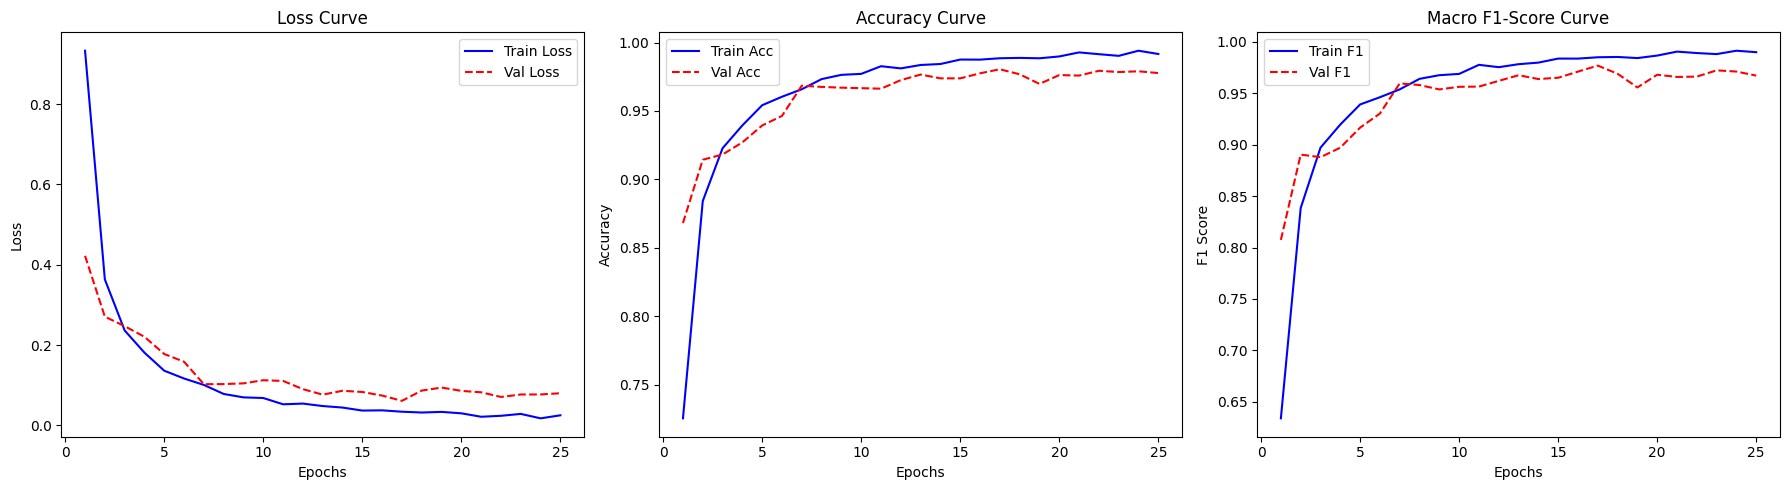

In [5]:
import matplotlib.pyplot as plt

def plot_history(history):
    epochs = range(1, len(history['train_acc']) + 1)
    
    plt.figure(figsize=(18, 5))

    # Plot 1: Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r--', label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot 2: Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    plt.plot(epochs, history['val_acc'], 'r--', label='Val Acc')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot 3: Macro F1-Score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['train_f1'], 'b-', label='Train F1')
    plt.plot(epochs, history['val_f1'], 'r--', label='Val F1')
    plt.title('Macro F1-Score Curve')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Run the visualization
plot_history(history)

# Testing and Performance Evaluation
Final evaluation to see how the CRNN compares to your Transformer's 77.2%.


--- CRNN Final Performance ---
Test Accuracy: 0.9785
Test F1 (Macro): 0.9722


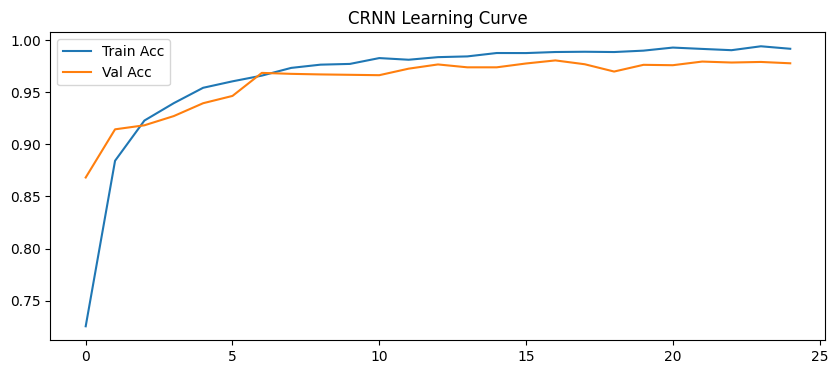

In [6]:
model.eval()
test_preds, test_labels = [], []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outs = model(imgs)
        _, p = torch.max(outs, 1)
        test_preds.extend(p.cpu().numpy())
        test_labels.extend(lbls.cpu().numpy())

print("\n--- CRNN Final Performance ---")
print(f"Test Accuracy: {np.mean(np.array(test_preds) == np.array(test_labels)):.4f}")
print(f"Test F1 (Macro): {f1_score(test_labels, test_preds, average='macro'):.4f}")

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('CRNN Learning Curve')
plt.legend()
plt.show()